In [1]:
# HIDDEN
using CSV
using DataFrames
using Statistics
using StatsPlots
Base.displaysize() = (5, 80)

## Multiple Linear Regression

Our simple linear model has a key advantage over the constant model: it uses the data when making predictions. However, it is still rather limited since simple linear models only use one variable in our dataset. Many datasets have many potentially useful variables, and multiple linear regression can take advantage of that. For example, consider the following dataset on car models and their milage per gallon (MPG):

In [8]:
mpg = dropmissing(CSV.read("mpg.csv"))
rename!(mpg, Symbol("model year") => :model_year)
rename!(mpg, Symbol("car name") => :car_name)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
,Float64,Int64,Float64,Float64,Float64,Float64,Int64
1,18.0,8,307.0,130.0,3504.0,12.0,70
2,15.0,8,350.0,165.0,3693.0,11.5,70
3,18.0,8,318.0,150.0,3436.0,11.0,70
4,16.0,8,304.0,150.0,3433.0,12.0,70
5,17.0,8,302.0,140.0,3449.0,10.5,70
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


It seems likely that multiple attributes of a car model will affect its MPG. For example, the MPG seems to decrease as horsepower increases:

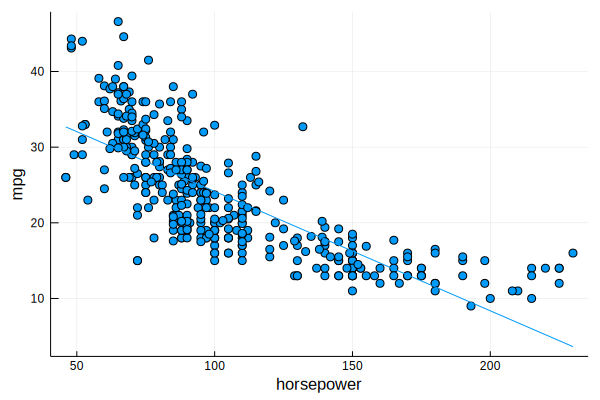

In [9]:
# HIDDEN
@df mpg scatter(:horsepower, :mpg, regression=true, xlabel="horsepower", ylabel="mpg", legend=false)

However, cars released later generally have better MPG than older cars:

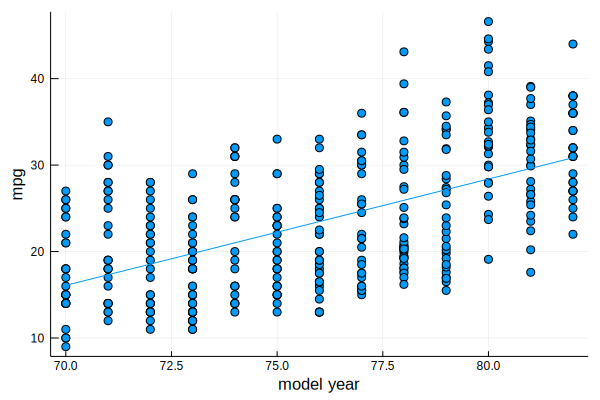

In [11]:
@df mpg scatter(:model_year, :mpg, regression=true, xlabel="model year", ylabel="mpg", legend=false)

It seems possible that we can get a more accurate model if we could take both horsepower and model year into account when making predictions about the MPG. In fact, perhaps the best model takes into account all the numerical variables in our dataset. We can extend our univariate linear regression to allow prediction based on any number of attributes.

We state the following model:

$$
f_\boldsymbol\theta (\textbf{x}) = \theta_0 + \theta_1 x_1 + \ldots + \theta_p x_p
$$

Where $ \textbf{x} $ now represents a vector containing $ p $ attributes of a single car. The model above says, "Take multiple attributes of a car, multiply them by some weights, and add them together to make a prediction for MPG."


For example, if we're making a prediction on the first car in our dataset using the horsepower, weight, and model year columns, the vector $ \textbf{x} $ looks like:

In [12]:
# HIDDEN
mpg[1, [:horsepower, :weight, :model_year]]

,horsepower,weight,model_year
,Float64,Float64,Int64
1,130.0,3504.0,70


In the examples, we've kept the column names for clarity but keep in mind that $ \textbf{x} $ only contains the numerical values of the table above: $ \textbf{x} = [130.0, 3504.0, 70] $.

Now, we will perform a notational trick that will greatly simplify later formulas. We will prepend the value $ 1 $ to the vector $ \textbf{x} $, so that we have the following vector for $ \textbf{x} $:

In [13]:
# HIDDEN
mpg_mat = deepcopy(mpg)
mpg_mat[!, :bias] .= 1
mpg_mat[1, [:bias, :horsepower, :weight, :model_year]]

,bias,horsepower,weight,model_year
,Int64,Float64,Float64,Int64
1,1,130.0,3504.0,70


Now, observe what happens to the formula for our model:

$$
\begin{aligned}
f_\boldsymbol\theta (\textbf{x})
&= \theta_0 + \theta_1 x_1 + \ldots + \theta_p x_p \\
&= \theta_0 (1) + \theta_1 x_1 + \ldots + \theta_p x_p \\
&= \theta_0 x_0 + \theta_1 x_1 + \ldots + \theta_p x_p \\
f_\boldsymbol\theta (\textbf{x}) &= \boldsymbol\theta \cdot \textbf{x}
\end{aligned}
$$

Where $ \boldsymbol\theta \cdot \textbf{x} $ is the vector dot product of $ \boldsymbol\theta $ and $ \textbf{x} $. Vector and matrix notation were designed to succinctly write linear combinations and is thus well-suited for our linear models. However, you will have to remember from now on that $ \boldsymbol\theta \cdot \textbf{x} $ is a vector-vector dot product. When in doubt, you can always expand the dot product into simple multiplications and additions.

Now, we define the matrix $  \textbf{X} $ as the matrix containing every car model as a row and a first column of biases. For example, here are the first five rows of $  \textbf{X} $:

In [15]:
# HIDDEN
mpg_mat[1:5, [:bias, :horsepower, :weight, :model_year]]

,bias,horsepower,weight,model_year
,Int64,Float64,Float64,Int64
1,1,130.0,3504.0,70
2,1,165.0,3693.0,70
3,1,150.0,3436.0,70
4,1,150.0,3433.0,70
5,1,140.0,3449.0,70


Again, keep in mind that the actual matrix $  \textbf{X} $ only contains the numerical values of the table above.

Notice that $ \textbf{X} $ is composed of multiple $ \textbf{x} $ vectors stacked on top of each other. To keep the notation clear, we define $ \textbf{X}_{i} $ to refer to the row vector with index $ i $ of $  \textbf{X} $. We define $ X_{i,j} $ to refer to the element with index $ j $ of the row with index $ i $ of $  \textbf{X} $. Thus, $ \textbf{X}_i $ is a $ p $-dimensional vector and $ X_{i,j} $ is a scalar. $  \textbf{X} $ is an $ n \times p $ matrix, where $n$ is the number of car examples we have and $p$ is the number of attributes we have for a single car.

For example, from the table above we have $ \textbf{X}_4 = [1, 140, 3449, 70] $ and $ X_{4,1} = 140 $. This notation becomes important when we define the loss function since we will need both $  \textbf{X} $, the matrix of input values, and $ \textbf{y} $, the vector of MPGs.

## MSE Loss and its Gradient

The mean squared error loss function takes in a vector of weights $ \boldsymbol\theta $, a matrix of inputs $  \textbf{X} $, and a vector of observed MPGs $ \textbf{y} $:

$$
\begin{aligned}
L(\boldsymbol\theta, \textbf{X}, \textbf{y})
&= \frac{1}{n} \sum_{i}(y_i - f_\boldsymbol\theta (\textbf{X}_i))^2\\
\end{aligned}
$$

We've previously derived the gradient of the MSE loss with respect to $ \boldsymbol\theta $:

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{X}, \textbf{y})
&= -\frac{2}{n} \sum_{i}(y_i - f_\boldsymbol\theta (\textbf{X}_i))(\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{X}_i))\\
\end{aligned}
$$

We know that:

$$
\begin{aligned}
f_\boldsymbol\theta (\textbf{x}) &= \boldsymbol\theta \cdot \textbf{x} \\
\end{aligned}
$$

Let's now compute $ \nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{x}) $. The result is surprisingly simple because $ \boldsymbol\theta \cdot \textbf{x} = \theta_0 x_0 + \ldots + \theta_p x_p $ and thus $ \frac{\partial}{\partial \theta_0}(\boldsymbol\theta \cdot \textbf{x}) = x_0 $, $ \frac{\partial}{\partial \theta_1}(\boldsymbol\theta \cdot \textbf{x}) = x_1 $, and so on.

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{x})
&= \nabla_{\boldsymbol\theta} [ \boldsymbol\theta \cdot \textbf{x} ] \\
&= \begin{bmatrix}
     \frac{\partial}{\partial \theta_0} (\boldsymbol\theta \cdot \textbf{x}) \\
     \frac{\partial}{\partial \theta_1} (\boldsymbol\theta \cdot \textbf{x}) \\
     \vdots \\
     \frac{\partial}{\partial \theta_p} (\boldsymbol\theta \cdot \textbf{x}) \\
   \end{bmatrix} \\
&= \begin{bmatrix}
     x_0 \\
     x_1 \\
     \vdots \\
     x_p
   \end{bmatrix} \\
\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{x}) &= \textbf{x}
\end{aligned}
$$

Finally, we plug this result back into our gradient calculations:

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{X}, \textbf{y})
&= -\frac{2}{n} \sum_{i}(y_i - f_\boldsymbol\theta (\textbf{X}_i))(\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{X}_i))\\
&= -\frac{2}{n} \sum_{i}(y_i - \boldsymbol\theta \cdot \textbf{X}_i)(\textbf{X}_i)\\
\end{aligned}
$$

Remember that since $ y_i - \boldsymbol\theta \cdot \textbf{X}_i $ is a scalar and $ \textbf{X}_i $ is a $ p $-dimensional vector, the gradient $ \nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{X}, \textbf{y}) $ is a $ p $-dimensional vector.

We saw this same type of result when we computed the gradient for univariate linear regression and found that it was 2-dimensional since $ \boldsymbol\theta $ was 2-dimensional.

## Fitting the Model With Gradient Descent

We can now plug in our loss and its derivative into gradient descent. As usual, we will define the model, loss, and gradient loss in Julia.

In [16]:
function linear_model(thetas, X)
end

linear_model (generic function with 1 method)